In [ ]:
!pip install scikit-learn scipy plotly statsmodels scikeras seaborn 

In [21]:
!pip install pandas_profiling

     ---------------------------------------- 0.0/109.4 kB ? eta -:--:--
     --- ------------------------------------ 10.2/109.4 kB ? eta -:--:--
     ------------- ----------------------- 41.0/109.4 kB 495.5 kB/s eta 0:00:01
     ------------------------------- ----- 92.2/109.4 kB 581.0 kB/s eta 0:00:01
     --------------------------------- -- 102.4/109.4 kB 535.8 kB/s eta 0:00:01
     ------------------------------------ 109.4/109.4 kB 488.6 kB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ---------------------------------------- 0.0/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:--
     ------- -------------------------------- 10.2/57.6 kB ? eta -:--:

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.0 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.


In [4]:
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.losses import Huber, MeanAbsoluteError, MAPE, MAE
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate, optimize
from scipy.stats import poisson
import pandas as pd
import json
import csv
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import re
import ast
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import MaxPooling1D, Flatten, LSTM, Bidirectional, Dense, Dropout, Conv1D, SimpleRNN, GRU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import MeanAbsolutePercentageError, RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import set_epsilon
from tensorflow import keras
from scipy.integrate import odeint
from scipy.optimize import differential_evolution
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from scikeras.wrappers import KerasRegressor


In [9]:
df = pd.read_csv("./data/hanoi_data.csv", parse_dates=['Date'], dayfirst=True)
# df = df[(df['Date'] >= '2021-04-5') & (df['Date'] <= '2021-10-19')]
df.tail(5)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19848\3715311377.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv("./data/hanoi_data.csv", parse_dates=['Date'], dayfirst=True)


,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change
1514,2024-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1515,2024-04-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1516,2024-04-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1517,2024-04-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1518,2024-04-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## EDA

In [15]:
df.isna().sum()

Date                       0
daily_cases              542
retail_and_recreation    545
grocery_and_pharmacy     545
parks_change             545
transit_stations         545
workplaces               906
residential_change       545
dtype: int64

In [16]:
df.dtypes

Date                     datetime64[ns]
daily_cases                     float64
retail_and_recreation           float64
grocery_and_pharmacy            float64
parks_change                    float64
transit_stations                float64
workplaces                      float64
residential_change              float64
dtype: object

In [17]:
df.index

RangeIndex(start=0, stop=1519, step=1)

In [19]:
print(df['Date'].unique())

<DatetimeArray>
['2020-02-15 00:00:00', '2020-02-16 00:00:00', '2020-02-17 00:00:00',
 '2020-02-18 00:00:00', '2020-02-19 00:00:00', '2020-02-20 00:00:00',
 '2020-02-21 00:00:00', '2020-02-22 00:00:00', '2020-02-23 00:00:00',
 '2020-02-24 00:00:00',
 ...
 '2024-04-03 00:00:00', '2024-04-04 00:00:00', '2024-04-05 00:00:00',
 '2024-04-06 00:00:00', '2024-04-07 00:00:00', '2024-04-08 00:00:00',
 '2024-04-09 00:00:00', '2024-04-10 00:00:00', '2024-04-11 00:00:00',
 '2024-04-12 00:00:00']
Length: 1519, dtype: datetime64[ns]


In [20]:
df.describe()

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change
count,1519,977.000000,974.000000,974.000000,974.000000,974.000000,613.000000,974.000000
mean,2022-03-15 00:00:00,1672.724667,-25.291581,-9.950719,-22.379877,-30.336756,-8.026101,7.328542
min,2020-02-15 00:00:00,0.000000,-87.000000,-67.000000,-83.000000,-89.000000,-84.000000,-13.000000
25%,2021-02-28 12:00:00,0.000000,-35.750000,-17.000000,-33.000000,-52.000000,-17.000000,3.000000
50%,2022-03-15 00:00:00,4.000000,-19.500000,-5.000000,-19.000000,-24.000000,-2.000000,6.000000
75%,2023-03-29 12:00:00,239.000000,-9.000000,2.000000,-8.000000,-9.000000,10.000000,9.000000
max,2024-04-12 00:00:00,225694.000000,21.000000,22.000000,38.000000,56.000000,30.000000,43.000000
std,NaN,12218.727641,22.534277,18.894678,22.425197,26.621583,25.346797,8.966012


In [27]:
from ydata_profiling import ProfileReport

# Generate the data profiling report 
report = ProfileReport(df, title='My Data')
report.to_file("report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 49.71it/s]


ADF Statistic: -0.4344656704512389
p-value: 0.9041832586097136
ADF Statistic after differencing: -2.271612736853363
p-value after differencing: 0.18128691370077782


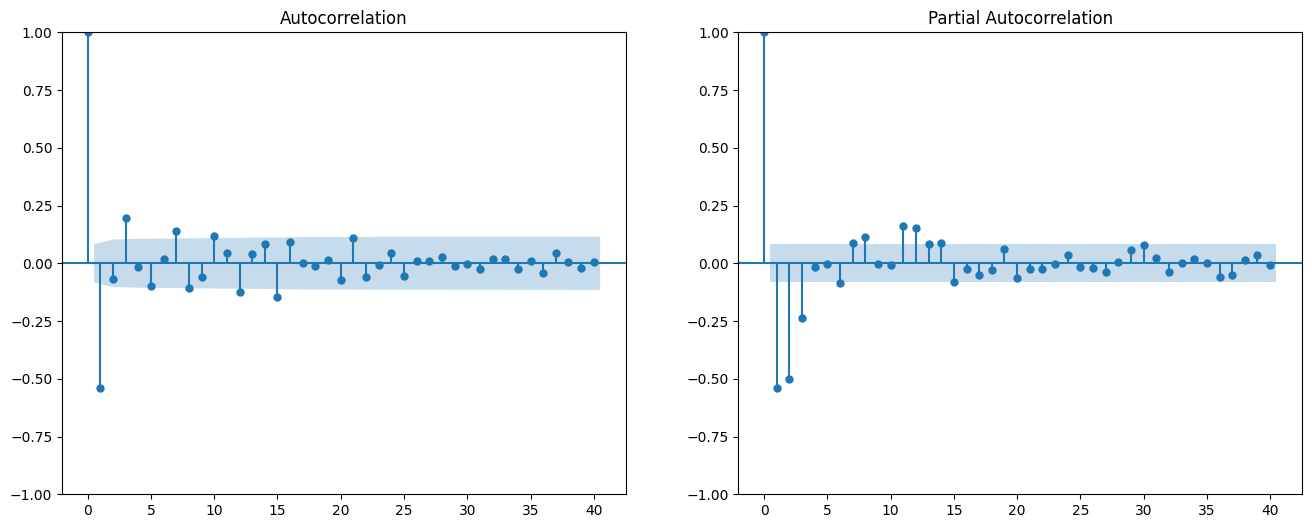

In [66]:
%matplotlib inline
# Check stationarity
result = adfuller(df_cleaned['daily_cases'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

# If not stationary, we difference the data
df_diff = df_cleaned['daily_cases'].diff().dropna()

# Check stationarity again after differencing
result = adfuller(df_diff)
print('ADF Statistic after differencing:', result[0])
print('p-value after differencing:', result[1])

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
plot_acf(df_diff, lags=40, ax=ax[0])
plot_pacf(df_diff, lags=40, ax=ax[1])
plt.show()


## Feature engineering

In [28]:
df['year']=df['Date'].dt.year 
df['month']=df['Date'].dt.month 
df['day']=df['Date'].dt.day
df.head(5)

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change,year,month,day
0,2020-02-15,NaN,-8.0,-4.0,-5.0,-14.0,-4.0,7.0,2020,2,15
1,2020-02-16,NaN,-15.0,-9.0,-11.0,-20.0,-5.0,8.0,2020,2,16
2,2020-02-17,NaN,-16.0,-12.0,-10.0,-19.0,3.0,7.0,2020,2,17
3,2020-02-18,NaN,-14.0,-9.0,-9.0,-18.0,10.0,8.0,2020,2,18
4,2020-02-19,NaN,-8.0,-16.0,-15.0,-21.0,9.0,6.0,2020,2,19


In [39]:
df['lag_1'] = df['daily_cases'].shift(1)
df['lag_2'] = df['daily_cases'].shift(2)
df['lag_3'] = df['daily_cases'].shift(3)



In [46]:
# rolling window
df['rolling_window'] = df['daily_cases'].rolling(window=14).mean()


In [47]:
df['expanding_mean'] = df['daily_cases'].expanding(3).mean()


In [50]:
df_cleaned = df.dropna()
df_cleaned.tail(20)

,Date,daily_cases,retail_and_recreation,grocery_and_pharmacy,parks_change,transit_stations,workplaces,residential_change,year,month,day,lag_1,lag_2,lag_3,rolling_window,expanding_mean
593,2021-09-30,56.0,-45.0,-28.0,-43.0,-62.0,-32.0,9.0,2021,9,30,37.0,31.0,26.0,18.642857,8.622776
594,2021-10-01,46.0,-52.0,-21.0,-43.0,-68.0,-37.0,12.0,2021,10,1,56.0,37.0,31.0,21.214286,8.689165
595,2021-10-02,57.0,-49.0,-13.0,-38.0,-67.0,-38.0,13.0,2021,10,2,46.0,56.0,37.0,24.857143,8.774823
596,2021-10-03,56.0,-44.0,-6.0,-28.0,-66.0,-41.0,10.0,2021,10,3,57.0,46.0,56.0,28.071429,8.858407
597,2021-10-04,76.0,-55.0,-27.0,-39.0,-70.0,-34.0,12.0,2021,10,4,56.0,57.0,46.0,32.785714,8.977032
598,2021-10-05,100.0,-48.0,-11.0,-34.0,-64.0,-29.0,11.0,2021,10,5,76.0,56.0,57.0,39.285714,9.137566
599,2021-10-06,91.0,-47.0,-25.0,-39.0,-68.0,-28.0,10.0,2021,10,6,100.0,76.0,56.0,45.214286,9.281690
600,2021-10-07,116.0,-41.0,-24.0,-37.0,-60.0,-29.0,7.0,2021,10,7,91.0,100.0,76.0,53.000000,9.469244
601,2021-10-08,72.0,-49.0,-19.0,-39.0,-67.0,-34.0,11.0,2021,10,8,116.0,91.0,100.0,57.142857,9.578947
602,2021-10-09,111.0,-52.0,-21.0,-43.0,-68.0,-34.0,13.0,2021,10,9,72.0,116.0,91.0,63.785714,9.756567


In [55]:
#@title data preparation, sequence_length = 7, only normalize the training set
feature_columns = df.columns.difference(['Date'])
X_data = df_cleaned[feature_columns].values
y_data = df_cleaned['daily_cases'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=10/len(df_cleaned), random_state=42, shuffle=True)

# Normalize the data using only the training data
scaler_X_train = StandardScaler()
scaler_y_train = StandardScaler()
scaler_X_test = StandardScaler()
scaler_y_test = StandardScaler()

X_train_scaled = scaler_X_train.fit_transform(X_train)
y_train_scaled = scaler_y_train.fit_transform(y_train.reshape(-1, 1))
X_test_scaled = scaler_X_test.fit_transform(X_test)
y_test_scaled = scaler_y_test.fit_transform(y_test.reshape(-1, 1))

def create_sequences(features, target, sequence_length):
    sequences = []
    labels = []
    for i in range(len(features) - sequence_length):
        sequence = features[i:i + sequence_length]
        label = target[i + sequence_length]
        sequences.append(sequence)
        labels.append(label)
    return np.array(sequences), np.array(labels)

sequence_length = 3
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled.reshape(-1,1), sequence_length)

print(X_train_seq.shape, y_train_seq.shape, X_test_seq.shape, y_test_seq.shape)

(555, 3, 15) (555, 1) (7, 3, 15) (7, 1)


## Deep learning model

### LSTM

In [16]:
#@title model architecture

lstm_model = Sequential()
lstm_model.add(LSTM(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
lstm_model.add(Dense(8, 'relu'))
lstm_model.add(Dense(1, 'linear'))
keras.backend.set_epsilon(1)
lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
lstm_model.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,017 (171.94 KB)

 Trainable params: 44,017 (171.94 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# Import necessary modules


# Define a function to create the Keras model
def create_model():
    model = Sequential()
    model.add(LSTM(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='linear'))
    K.set_epsilon(1)
    model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
    return model

# Wrap the Keras model using KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the parameter grid
batch_size = [8, 16, 32]
epochs = [200, 300, 500]
param_grid = dict(batch_size=batch_size, epochs=epochs)

# Perform Grid Search with appropriate scoring for regression
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, scoring='neg_mean_absolute_error', error_score='raise')

# Check shapes and data types
print(X_train_seq.shape)
print(y_train_seq.shape)
print(X_train_seq.dtype if hasattr(X_train_seq, 'dtype') else "Not a DataFrame")
print(y_train_seq.dtype if hasattr(y_train_seq, 'dtype') else "Not a Series")

# Try a single fit to see if it works
try:
    single_model = create_model()
    single_model.fit(X_train_seq, y_train_seq, epochs=1, batch_size=8)
    print("Single fit successful")
except ValueError as e:
    print(f"Single fit ValueError: {e}")

# Fit the grid search
try:
    grid_result = grid.fit(X_train_seq, y_train_seq)
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
except ValueError as e:
    print(f"GridSearchCV ValueError: {e}")


(185, 3, 7)
(185, 1)
float64
float64
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6381 - mean_absolute_percentage_error: 51.0362
Single fit successful


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Best: -1.163155 using {'batch_size': 8, 'epochs': 500}


In [21]:
#@title training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = lstm_model.fit(X_train_seq, y_train_seq, epochs=500, batch_size=8, validation_split=0.2, verbose=1)


Epoch 1/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3160 - mean_absolute_percentage_error: 24.0245 - val_loss: 0.3894 - val_mean_absolute_percentage_error: 29.2061
Epoch 2/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3569 - mean_absolute_percentage_error: 28.9089 - val_loss: 0.3627 - val_mean_absolute_percentage_error: 26.9128
Epoch 3/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3754 - mean_absolute_percentage_error: 27.4137 - val_loss: 0.5157 - val_mean_absolute_percentage_error: 40.4992
Epoch 4/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3325 - mean_absolute_percentage_error: 25.3950 - val_loss: 0.3717 - val_mean_absolute_percentage_error: 27.0682
Epoch 5/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3922 - mean_absolute_percentage_error: 26.0689 - val_loss: 0.3925 - val_mean_absolute_percentage_error: 29.3276
Epoch 6/500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3986 - mean_absolute_percentage_error: 29.6085 - val_loss: 0.3395 - val_me

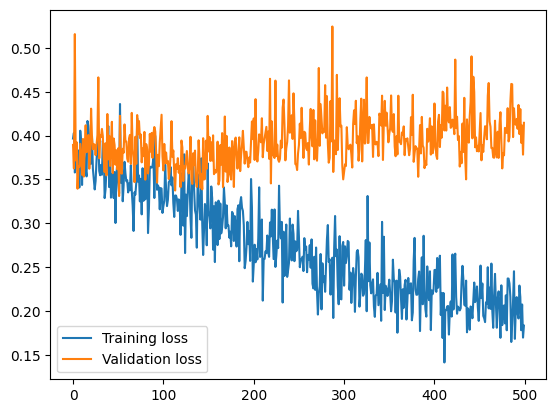

In [22]:
#@title plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [26]:
#@title visualization the result
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred_train = lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

# Add training data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

# Add testing data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

# Update layout
fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [24]:
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


MAE: 0.8316758871078491
RMSE: 0.9796064496040344
R² score: -0.47953367233276367


In [ ]:
model.save('./checkpoints/LSTM.h5')


### RNN

In [27]:
rnn_model = Sequential()
rnn_model.add(SimpleRNN(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
rnn_model.add(Dense(8, activation='relu'))
rnn_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
rnn_model.summary()

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 100)            │        10,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,617 (45.38 KB)

 Trainable params: 11,617 (45.38 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
#@title training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = rnn_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 83ms/step - loss: 1.1683 - mean_absolute_percentage_error: 103.0530 - val_loss: 0.5683 - val_mean_absolute_percentage_error: 49.9259
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8823 - mean_absolute_percentage_error: 74.5979 - val_loss: 0.5401 - val_mean_absolute_percentage_error: 48.2981
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7044 - mean_absolute_percentage_error: 62.6789 - val_loss: 0.4130 - val_mean_absolute_percentage_error: 36.2705
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6660 - mean_absolute_percentage_error: 56.1669 - val_loss: 0.3879 - val_mean_absolute_percentage_error: 33.2552
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5736 - mean_absolute_percentage_error: 49.2198 - val_loss: 0.3640 - val_mean_absolute_percentage_error: 31.5595
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5693 - mean_absolute_percentage_error: 47.5452 - val_loss: 0.3667 - val_mean_absolu

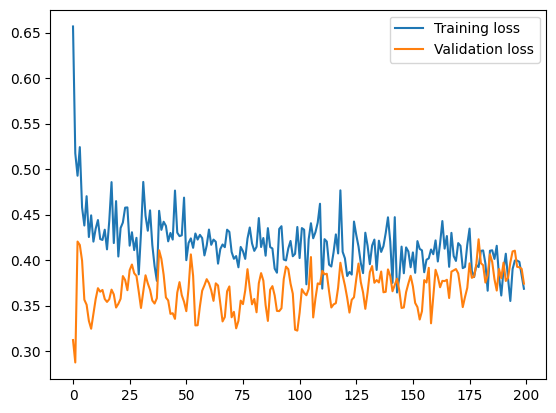

In [ ]:
#@title plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [ ]:
#@title visualization the result
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

y_pred_train = rnn_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = rnn_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

# Create subplots
fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

# Add training data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

# Add testing data traces
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

# Update layout
fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )

# Show the plot
fig.show()



6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


In [ ]:
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


MAE: 0.7006569504737854
RMSE: 0.9111506938934326
R² score: -0.279976487159729


In [30]:
rnn_model.save("./checkpoints/rnn.h5")

### GRU

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 100)            │        32,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,517 (130.93 KB)

 Trainable params: 33,517 (130.93 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - loss: 0.8028 - mean_absolute_percentage_error: 62.1673 - val_loss: 0.7747 - val_mean_absolute_percentage_error: 64.2381
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6921 - mean_absolute_percentage_error: 53.2156 - val_loss: 0.6787 - val_mean_absolute_percentage_error: 55.3657
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5940 - mean_absolute_percentage_error: 47.1879 - val_loss: 0.5732 - val_mean_absolute_percentage_error: 45.9263
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5889 - mean_absolute_percentage_error: 42.0921 - val_loss: 0.4786 - val_mean_absolute_percentage_error: 37.5677
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.5619 - mean_absolute_percentage_error: 40.4015 - val_loss: 0.3926 - val_mean_absolute_percentage_error: 30.2695
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4246 - mean_absolute_percentage_error: 34.0114 - val_loss: 0.3698 - val_mean_ab

MAE: 0.8316758871078491
RMSE: 0.9796064496040344
R² score: -0.47953367233276367


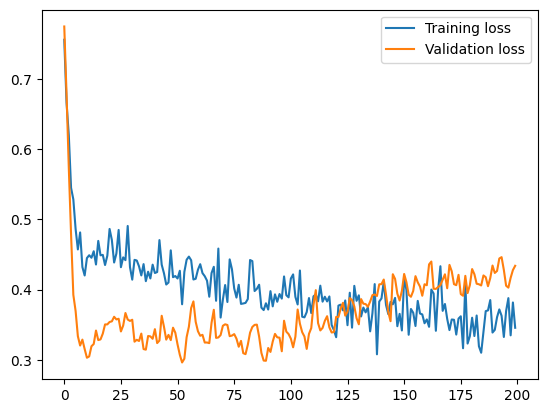

In [15]:
gru_model = Sequential()
gru_model.add(GRU(100, dropout=0.2, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
gru_model.add(Dense(8, activation='relu'))
gru_model.add(Dense(1, activation='linear'))
set_epsilon(1)
gru_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
gru_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = gru_model.fit(X_train_seq, y_train_seq, epochs=200, batch_size=32, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = gru_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = gru_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
gru_model.save("./checkpoints/gru.h5")


### bidirectional LSTM

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 200)            │        86,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 8)              │         1,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88,017 (343.82 KB)

 Trainable params: 88,017 (343.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.6908 - mean_absolute_percentage_error: 55.9927 - val_loss: 0.5580 - val_mean_absolute_percentage_error: 44.8193
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6350 - mean_absolute_percentage_error: 47.6693 - val_loss: 0.4566 - val_mean_absolute_percentage_error: 36.0338
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5490 - mean_absolute_percentage_error: 38.5562 - val_loss: 0.3224 - val_mean_absolute_percentage_error: 24.1646
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.4247 - mean_absolute_percentage_error: 33.8517 - val_loss: 0.3033 - val_mean_absolute_percentage_error: 22.9354
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4413 - mean_absolute_percentage_error: 31.1017 - val_loss: 0.3481 - val_mean_absolute_percentage_error: 27.3129
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4139 - mean_absolute_percentage_error: 31.6709 - val_loss: 0.3997 - val_m

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


MAE: 0.8357642889022827
RMSE: 0.9913323521614075
R² score: -0.5151656866073608


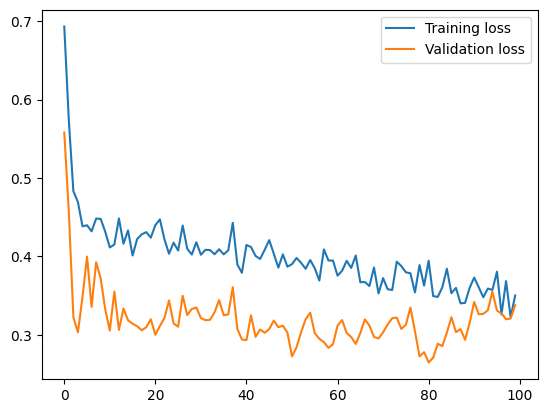

In [33]:
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(100, dropout=0.2, return_sequences=False), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
bilstm_model.add(Dense(8, activation='relu'))
bilstm_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
bilstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = bilstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = bilstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = bilstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
bilstm_model.save("./checkpoints/bilstm.h5")


### stacked LSTM

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 3, 100)         │        43,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,817 (288.35 KB)

 Trainable params: 73,817 (288.35 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.7301 - mean_absolute_percentage_error: 59.6034 - val_loss: 0.7219 - val_mean_absolute_percentage_error: 58.9669
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6457 - mean_absolute_percentage_error: 53.7169 - val_loss: 0.6893 - val_mean_absolute_percentage_error: 56.5477
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6940 - mean_absolute_percentage_error: 49.9200 - val_loss: 0.6338 - val_mean_absolute_percentage_error: 52.4032
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5064 - mean_absolute_percentage_error: 40.4548 - val_loss: 0.5036 - val_mean_absolute_percentage_error: 41.4075
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5213 - mean_absolute_percentage_error: 39.7003 - val_loss: 0.3770 - val_mean_absolute_percentage_error: 29.8490
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4807 - mean_absolute_percentage_error: 36.0845 - val_loss: 0.3066 - val_m

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


MAE: 0.7931345105171204
RMSE: 0.959028422832489
R² score: -0.4180271625518799


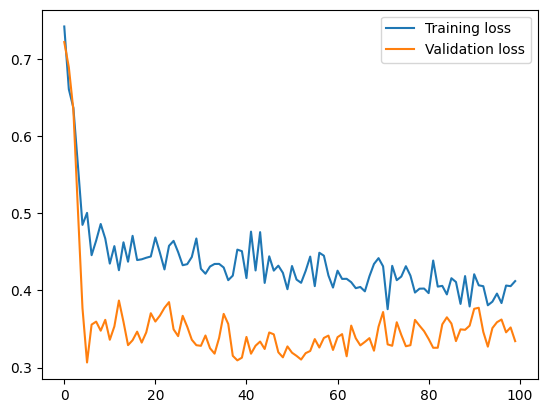

In [31]:
stacked_lstm_model = Sequential()
stacked_lstm_model.add(LSTM(100, dropout=0.2, return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
stacked_lstm_model.add(LSTM(50, dropout=0.2, return_sequences=False))  # No need for input_shape here
stacked_lstm_model.add(Dense(8, activation='relu'))
stacked_lstm_model.add(Dense(1, activation='linear'))
K.set_epsilon(1)
stacked_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])
stacked_lstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = stacked_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=1)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = stacked_lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = stacked_lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
stacked_lstm_model.save("./checkpoints/stacked_lstm.h5")


### Convolutional LSTM

In [56]:
conv_lstm_model = Sequential()
conv_lstm_model.add(Conv1D(64, 2, activation='relu', input_shape=(3, 15)))  # Use kernel size 2 to fit the small input
conv_lstm_model.add(MaxPooling1D(pool_size=1))  # Pooling size 1 to prevent negative dimensions
conv_lstm_model.add(LSTM(100, return_sequences=True))
conv_lstm_model.add(Dropout(0.2))
conv_lstm_model.add(Conv1D(32, 2, activation='relu'))  # Adjust kernel size to fit the reduced dimensions
conv_lstm_model.add(MaxPooling1D(pool_size=1))  # Pooling size 1 to prevent negative dimensions
conv_lstm_model.add(Flatten())
conv_lstm_model.add(Dense(units=1))
set_epsilon(1)
conv_lstm_model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanAbsoluteError(), metrics=[MeanAbsolutePercentageError()])

conv_lstm_model.summary()


# training
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5, min_lr=0.00000001)

history = conv_lstm_model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=16, validation_split=0.2, verbose=2)


# plot the loss function
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()


# visualization the result
y_pred_train = conv_lstm_model.predict(X_train_seq).reshape(-1,1)
y_pred_test = conv_lstm_model.predict(X_test_seq).reshape(-1,1)

num_dates = len(df['Date'])
step = max(1, num_dates // 15)
display_dates = df['Date'][::step]

fig = make_subplots(
    rows=1, cols=2,
    subplot_titles=("Original Training Data"),
    shared_xaxes=True
)

fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_train_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=1)
fig.add_trace(go.Scatter(x=np.arange(len(X_train) - sequence_length + 1), y=y_pred_train.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=1)

fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_test_seq.flatten(), mode='lines', name='Original Training Data'), row=1, col=2)
fig.add_trace(go.Scatter(x=np.arange(len(X_test) - sequence_length + 1), y=y_pred_test.flatten(), mode='lines', name='Fitted Training Data', line=dict(dash='dash')), row=1, col=2)

fig.update_layout(
    height=400, width=600,
    title_text="COVID-19 Data",
    hovermode='x unified'
)

for i in range(1, 2):
    for j in range(1, 3):
        fig.update_xaxes(
            tickvals=display_dates,
            tickformat="%b %d\n%Y",
            tickangle=45,
            row=i, col=j
        )
fig.show()


# Compute score metrics
# Convert to tensors
y_true_tf = tf.convert_to_tensor(y_test_seq.reshape(-1), dtype=tf.float32)
y_pred_tf = tf.convert_to_tensor(y_pred_test.reshape(-1), dtype=tf.float32)

# Initialize the metrics
mae_metric = tf.keras.metrics.MeanAbsoluteError()
mse_metric = tf.keras.metrics.MeanSquaredError()

# Update the state with the true and predicted values
mae_metric.update_state(y_true_tf, y_pred_tf)
mse_metric.update_state(y_true_tf, y_pred_tf)

# Calculate MAE and MSE
mae = mae_metric.result().numpy()
mse = mse_metric.result().numpy()

# Calculate RMSE
rmse = np.sqrt(mse)

# Calculate R² score
total_error = tf.reduce_sum(tf.square(y_true_tf - tf.reduce_mean(y_true_tf)))
unexplained_error = tf.reduce_sum(tf.square(y_true_tf - y_pred_tf))
r2_score = 1 - tf.divide(unexplained_error, total_error).numpy()

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² score: {r2_score}")


# save the model
conv_lstm_model.save("./checkpoints/conv_lstm.h5")


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 2, 64)          │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 2, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 2, 100)         │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1, 32)          │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,449 (290.82 KB)

 Trainable params: 74,449 (290.82 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
28/28 - 5s - 193ms/step - loss: 0.4199 - mean_absolute_percentage_error: 25.5236 - val_loss: 0.4596 - val_mean_absolute_percentage_error: 27.9848
Epoch 2/100
28/28 - 0s - 8ms/step - loss: 0.3937 - mean_absolute_percentage_error: 22.9733 - val_loss: 0.4645 - val_mean_absolute_percentage_error: 28.3784
Epoch 3/100
28/28 - 0s - 6ms/step - loss: 0.3870 - mean_absolute_percentage_error: 22.3193 - val_loss: 0.4543 - val_mean_absolute_percentage_error: 27.1837
Epoch 4/100
28/28 - 0s - 9ms/step - loss: 0.3809 - mean_absolute_percentage_error: 21.7062 - val_loss: 0.4505 - val_mean_absolute_percentage_error: 26.7542
Epoch 5/100
28/28 - 0s - 8ms/step - loss: 0.3777 - mean_absolute_percentage_error: 21.4751 - val_loss: 0.4580 - val_mean_absolute_percentage_error: 27.2481
Epoch 6/100
28/28 - 0s - 5ms/step - loss: 0.3765 - mean_absolute_percentage_error: 21.3835 - val_loss: 0.4547 - val_mean_absolute_percentage_error: 27.5463
Epoch 7/100
28/28 - 0s - 6ms/step - loss: 0.3793 - mean_absolu

MAE: 0.8439251184463501
RMSE: 1.2395340204238892
R² score: -0.2763173580169678


## SIR model

In [72]:
y_total = df_cleaned["daily_cases"].values[500:600]
x_total = np.arange(1, len(y_total) + 1)  # Correct number of elements

# Initial number of people in each compartment
N = 1000000  # Total population
p = 0.8  # Vaccination coverage
initial_state_values = [(1 - p) * N,  # Susceptible (unvaccinated)
                        1,            # Infected
                        0,            # Recovered
                        p * N,        # Vaccinated
                        0]            # Infected (vaccinated)

# Model function
def vaccine_model(state, t, beta, gamma, c_s, c_i):
    S, I, R, V, Iv = state
    lambda_ = beta * I / N + c_i * beta * Iv / N
    dS = -lambda_ * S
    dI = lambda_ * S - gamma * I
    dR = gamma * I + gamma * Iv
    dV = -c_s * lambda_ * V
    dIv = c_s * lambda_ * V - gamma * Iv
    return [dS, dI, dR, dV, dIv]

# Function to integrate the model
def integrate_model(state, t, beta, gamma, c_s, c_i):
    return odeint(vaccine_model, state, t, args=(beta, gamma, c_s, c_i))

# Function to calculate the mean squared error (MSE)
def mse(params, y_data):
    t = x_total
    solution = integrate_model(initial_state_values, t, *params)
    predicted_infected = solution[:, 1] + solution[:, 4]  # Sum of I and Iv compartments
    squared_errors = (y_data - predicted_infected) ** 2
    return np.mean(squared_errors)  # Calculate mean squared error

# Define bounds for parameters
bounds = [(0.01, 100),  # beta
          (0.1, 1.0), # gamma
          (0.1, 1.0), # c_s
          (0.1, 1.0)] # c_i

# Optimize using differential evolution
result = differential_evolution(mse, bounds, args=(y_total,), popsize=15, mutation=0.9, recombination=0.7, seed=123)

# Extract fitted parameters
beta_fit, gamma_fit, c_s_fit, c_i_fit = result.x

# Solve the model with the fitted parameters
fitted_solution = integrate_model(initial_state_values, x_total, beta_fit, gamma_fit, c_s_fit, c_i_fit)

# Plot the results


print("Estimated beta:", beta_fit)
print("Estimated gamma:", gamma_fit)
print("Estimated c_s:", c_s_fit)
print("Estimated c_i:", c_i_fit)

Estimated beta: 3.866610183297985
Estimated gamma: 1.0
Estimated c_s: 0.1
Estimated c_i: 0.9998890401298819


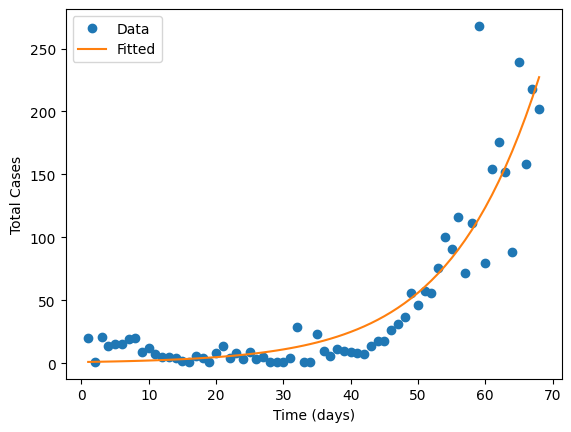

In [73]:
%matplotlib inline
plt.plot(x_total, y_total, 'o', label="Data")
plt.plot(x_total, fitted_solution[:, 1] + fitted_solution[:, 4], '-', label="Fitted")
plt.xlabel("Time (days)")
plt.ylabel("Total Cases")
plt.legend()
plt.show()

## ARIMA model

In [75]:
# Fit the ARIMA model
model = ARIMA(df_cleaned['daily_cases'], order=(5, 1, 5))
model_fit = model.fit()

# Print the model summary
(model_fit.summary())


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization fail

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            daily_cases   No. Observations:                  568
Model:                 ARIMA(5, 1, 5)   Log Likelihood               -2396.935
Date:                Sun, 16 Jun 2024   AIC                           4815.870
Time:                        11:59:58   BIC                           4863.614
Sample:                             0   HQIC                          4834.503
                                - 568                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.9370      0.141     13.753      0.000       1.661       2.213
ar.L2         -1.5634      0.279     -5.604      0.000      -2.110      -1.017
ar.L3          0.6422      0.246      2.616      0.009       0.161       1.123
ar.L4         -0.3587      0.105     -3.415      0.001      -0.565      -0.153
ar.L5          0.2485      0.041      6.008      0.000       0.167       0.330
ma.L1         -2.9509      0.142    -20.834      0.000      -3.229      -2.673
ma.L2          3.7069      0.428      8.663      0.000       2.868       4.546
ma.L3         -2.2700      0.564     -4.026      0.000      -3.375      -1.165
ma.L4          0.5463      0.374      1.460      0.144      -0.187       1.280
ma.L5          0.0255      0.110      0.232      0.816      -0.190       0.241
sigma2       275.1398      5.262     52.292      0.000     264.827     285.452
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):             29818.47
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):              12.39   Skew:                             3.32
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19848\2976500637.py:17: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

c:\Users\ADMIN\AppData\Loca

Best ARIMA(5, 0, 5) - AIC:3418.162013795969
MAPE: 480.42


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



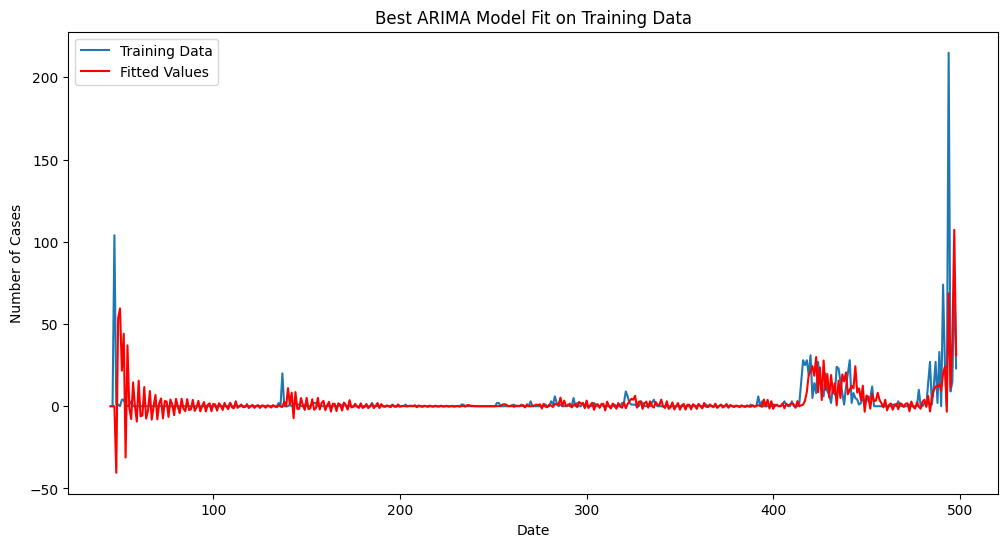

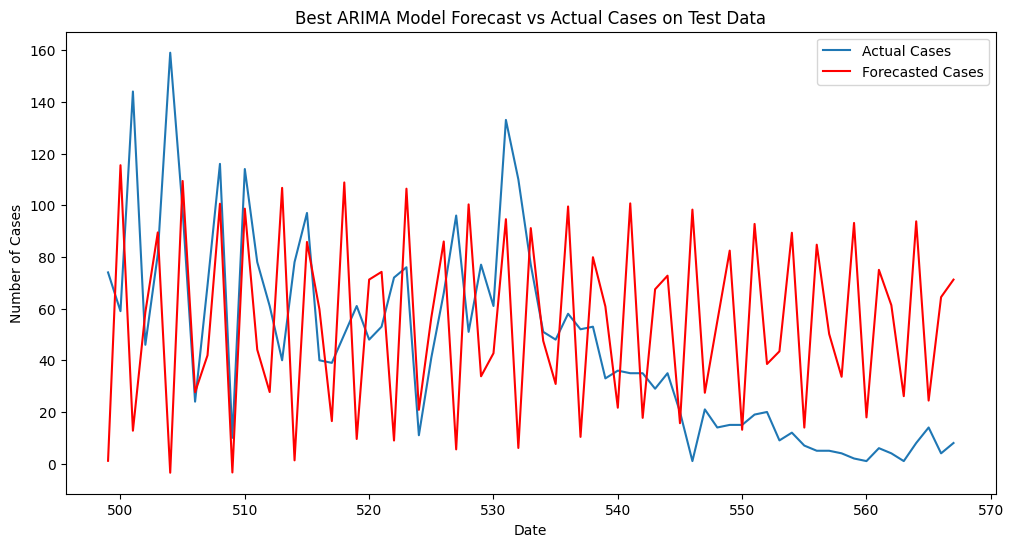

In [76]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

# Define the p, d and q parameters to take any value between 0 and 5
p = d = q = range(0, 6)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

# Check stationarity and differencing
result = adfuller(df_cleaned['daily_cases'])
if result[1] > 0.05:
    df_cleaned['daily_cases_diff'] = df_cleaned['daily_cases'].diff().dropna()
    d = 1
else:
    d = 0

# Split data into training and test set
train_size = int(len(df_cleaned) * 0.8)
train, test = df_cleaned['daily_cases'][:train_size], df_cleaned['daily_cases'][train_size:]

# Grid Search for ARIMA parameters
best_aic = float("inf")
best_pdq = None
best_model = None

for param in pdq:
    try:
        temp_model = ARIMA(train, order=(param[0], d, param[2]))
        results = temp_model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_pdq = param
            best_model = results
    except:
        continue

print(f'Best ARIMA{best_pdq} - AIC:{best_aic}')

# Forecast using the best model
forecast = best_model.forecast(steps=len(test))
forecast = pd.Series(forecast, index=test.index)

# Remove NaN values from the forecast and test sets
forecast = forecast.dropna()
test = test.loc[forecast.index].dropna()

# Define a custom MAPE function
def custom_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / np.maximum(y_true, 1e-10))) * 100

# Calculate MAPE
mape = custom_mape(test, forecast)
print(f'MAPE: {mape:.2f}')

# Visualize the model fit on training data
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training Data')
plt.plot(train.index, best_model.fittedvalues, color='red', label='Fitted Values')
plt.title('Best ARIMA Model Fit on Training Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()

# Visualize the forecast on test data
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual Cases')
plt.plot(forecast.index, forecast, label='Forecasted Cases', color='red')
plt.title('Best ARIMA Model Forecast vs Actual Cases on Test Data')
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.legend()
plt.show()
